|상세기준|
|:----|
|모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.|
|regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 체계적으로 수행되었다.|
|Accuracy 기준 85%에 도달하였다.|

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# 데이터 불러오기


In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 20

train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [3]:
# train val dataset 비율 변경(8:2)

# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [4]:
#데이터 확인

# 정상 이미지와 폐렴 이미지를 구분해야 하는데
# 다행히도 파일 경로에 힌트가 있어요
print(f'Normal image path\n{filenames[50]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person51_bacteria_246.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person124_virus_233.jpeg


In [5]:
# normal pneumonia 비율

# 이제 파일 경로에 NORMAL이 있는지 확인하면 정상 이미지를 셀 수 있습니다.
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

# 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 셀 수 있습니다.
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1091
Pneumonia images count in training set: 3094


# Dataset 생성

tf.data 관련 공부

In [6]:
# path_list를 Tensor  변환

train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

print(train_list_ds)
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

<TensorSliceDataset shapes: (), types: tf.string>
Training images count: 4185
Validating images count: 1047


In [7]:
# path_list에서 image 리스트로 변환

# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

#num_parallel_calls
train_dataset = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_dataset = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

print(train_dataset)

<ParallelMapDataset shapes: ((180, 180, 3), ()), types: (tf.float32, tf.bool)>


In [8]:
#Dataset 확인

for image, label in train_dataset.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


In [9]:
# Test dataset 생성

test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [10]:
# 학습 최적화를 위한 Dataset

def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size) # 무작위로 섞기
    ds = ds.repeat()                                 
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_dataset)
val_ds = prepare_for_training(val_dataset)

train_ds

<PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.bool)>

# Dataset 시각화

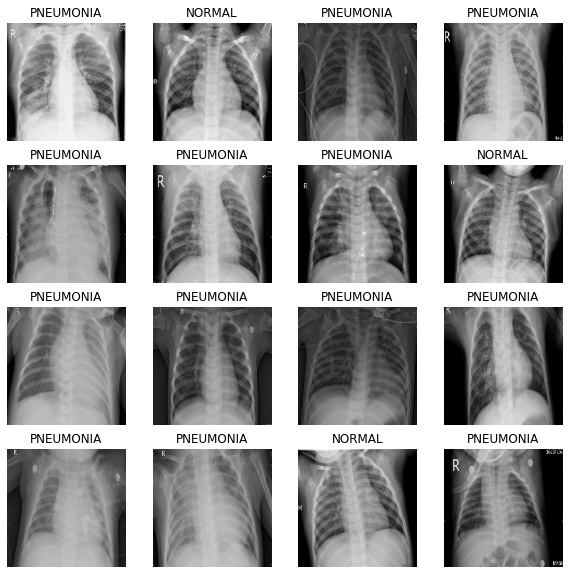

In [11]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

# Model 생성

In [12]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# Data Imbalace 해결
가중치 조절


In [13]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))


Weight for NORMAL: 1.92
Weight for PNEUMONIA: 0.68


# 학습 
Compile

In [14]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [15]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/20
261/261 [==============================] - 86s 196ms/step - loss: 0.3617 - accuracy: 0.8209 - precision: 0.9528 - recall: 0.7973 - val_loss: 0.6480 - val_accuracy: 0.7538 - val_precision: 0.7538 - val_recall: 1.0000
Epoch 2/20
261/261 [==============================] - 50s 192ms/step - loss: 0.2354 - accuracy: 0.9095 - precision: 0.9738 - recall: 0.9018 - val_loss: 1.2572 - val_accuracy: 0.7538 - val_precision: 0.7538 - val_recall: 1.0000
Epoch 3/20
261/261 [==============================] - 51s 194ms/step - loss: 0.1978 - accuracy: 0.9289 - precision: 0.9794 - recall: 0.9233 - val_loss: 0.3278 - val_accuracy: 0.8298 - val_precision: 0.8154 - val_recall: 1.0000
Epoch 4/20
261/261 [==============================] - 51s 197ms/step - loss: 0.1768 - accuracy: 0.9353 - precision: 0.9799 - recall: 0.9316 - val_loss: 0.0695 - val_accuracy: 0.9760 - val_precision: 0.9786 - val_recall: 0.9898
Epoch 5/20
261/261 [==============================] - 52s 200ms/step - loss: 0.1650 - accura

# 학습결과


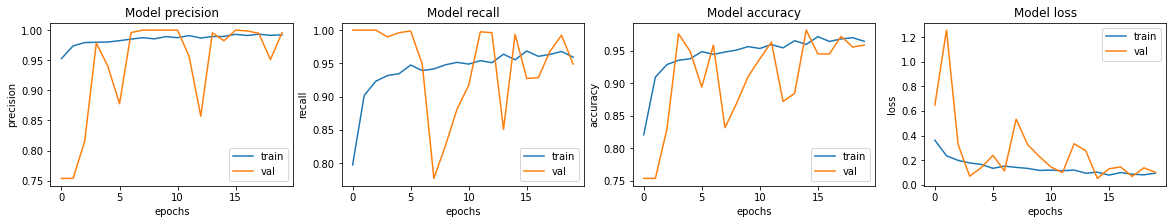

In [16]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

# 평가


In [17]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 107ms/step - loss: 0.5412 - accuracy: 0.8606 - precision: 0.8315 - recall: 0.9744
Loss: 0.5412217378616333,
Accuracy: 0.8605769276618958,
Precision: 0.8315098285675049,
Recall: 0.9743589758872986


# 정확도 향상

1. Hyper Parameter 
2. Data Augmnetation
3. Imbalance Usage

등을 수정해본다

## train test 

In [18]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

위 과정 통합 한 attempt 함수 작성

In [24]:
def attempt(train_ds=train_dataset, val_ds=val_dataset,
            BATCH_SIZE=16, EPOCHS=25, 
            optimizer='adam', loss_fn='binary_crossentropy', 
            weight=True, augmentation=False):
    
    train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
    val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

    test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
    TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
    test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
    test_ds = test_ds.batch(BATCH_SIZE)

    def augment(image,label):
        image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
        return image,label

    def prepare_for_training(ds, shuffle_buffer_size=1000):
        # augment 적용 부분이 배치처리 함수에 추가되었습니다.
        if augmentation:
            ds = ds.map(
                    augment,       # augment 함수 적용
                    num_parallel_calls=2
                )
        ds = ds.shuffle(buffer_size=shuffle_buffer_size)
        ds = ds.repeat()
        ds = ds.batch(BATCH_SIZE)
        ds = ds.prefetch(buffer_size=AUTOTUNE)

        return ds

    train_ds = prepare_for_training(train_ds)
    val_ds = prepare_for_training(val_ds)

    with tf.device('/GPU:0'):
        model = build_model()
        
        METRICS = [
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')]
        
        model.compile(
            optimizer=optimizer,
            loss=loss_fn,
            metrics=METRICS)
            
        history = model.fit(
            train_ds,
            steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
            epochs=EPOCHS,
            validation_data=val_ds,
            validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
            verbose=0)
        
    condition = {
        'batch_size' : BATCH_SIZE,
        'epochs' : EPOCHS,
        'loss_fn' : loss_fn,
        'optimizer' : optimizer,
        'class_weight' : class_weight,
        'augmentation' : augmentation}
    
    loss, accuracy, precision, recall = model.evaluate(test_ds)
    print('result')
    print(f'Loss: {loss} | Accuracy: {accuracy} | Precision: {precision} | Recall: {recall}')
    
    eval_result = {
        'loss' : loss,
        'accuracy' : accuracy,
        'precision' : precision,
        'recall' : recall}
    
    return history, eval_result, condition

In [25]:
# Batch size 변경, augmentation적용, optimizer 변경
history_first = attempt(BATCH_SIZE=32, augmentation=True, EPOCHS=20)    
history_second = attempt(BATCH_SIZE=16, augmentation=True,optimizer='rmsprop', EPOCHS=20) 



20/20 [==============================] - 5s 229ms/step - loss: 1.4171 - accuracy: 0.7083 - precision: 0.6825 - recall: 0.9974
result
Loss: 1.4170887470245361 | Accuracy: 0.7083333134651184 | Precision: 0.6824561357498169 | Recall: 0.9974358677864075
39/39 [==============================] - 5s 114ms/step - loss: 0.7329 - accuracy: 0.8349 - precision: 0.8073 - recall: 0.9667
result
Loss: 0.7329089045524597 | Accuracy: 0.8349359035491943 | Precision: 0.8072805404663086 | Recall: 0.9666666388511658


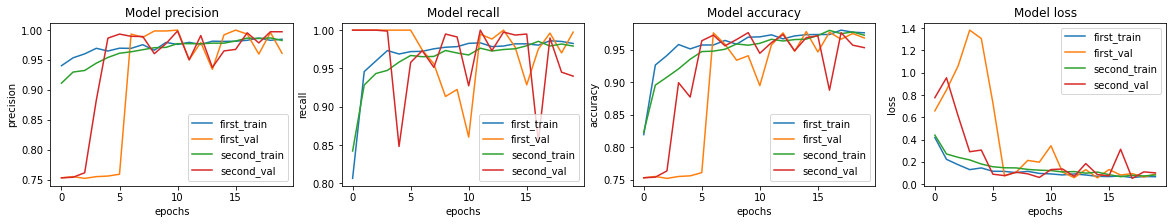

In [27]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

history_list = [history_first, history_second]
for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    for history in history_list:
        ax[i].plot(history[0].history[met])
        ax[i].plot(history[0].history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['first_train', 'first_val', 'second_train', 'second_val'])

In [28]:
for history in history_list:
    print(history[1]['accuracy'])

0.7083333134651184
0.8349359035491943


# 결과 및 고찰

+ augmentation 에서 tf.image.random_flip_left_right(image)가 랜덤하게 좌우반전된 이미지를 이용했지만 Batchsize가 32가 되면서 정확도는 더 떨어졌다.
+ augmentation을 한다고 모든 결과가 좋아지는건 아니고 data의 수가 적을때 효과적일거 같다.
+ class_weight과 같은 값도 Hyperparameter 수정을 해주는 것을 깨달았다.
+ optimizer도 변경한 값에서 차이가 조금 나지만 큰 차이는 나지 않았다.